In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.stats import mode, skew, entropy
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold



In [9]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data['ms'] = train_data['common_ts']
test_data['ms'] = test_data['common_ts']
train_data['common_ts'] = pd.to_datetime(train_data['common_ts'], unit='ms')
test_data['common_ts'] = pd.to_datetime(test_data['common_ts'], unit='ms')


train_data['x_mean'] = train_data[['x' + str(i) for i in range(1, 9)]].mean(axis=1)
train_data['x_std'] = train_data[['x' + str(i) for i in range(1, 9)]].std(axis=1)
test_data['x_mean'] = test_data[['x' + str(i) for i in range(1, 9)]].mean(axis=1)
test_data['x_std'] = test_data[['x' + str(i) for i in range(1, 9)]].std(axis=1)


train_data['x_Q1'] = train_data[['x' + str(i) for i in range(1, 9)]].quantile(0.25, axis=1)
test_data['x_Q1'] = test_data[['x' + str(i) for i in range(1, 9)]].quantile(0.25, axis=1)
train_data['x_Q3'] = train_data[['x' + str(i) for i in range(1, 9)]].quantile(0.75, axis=1)
test_data['x_Q3'] = test_data[['x' + str(i) for i in range(1, 9)]].quantile(0.75, axis=1)
train_data['x_skew'] = train_data[['x' + str(i) for i in range(1, 9)]].skew(axis=1)
test_data['x_skew'] = test_data[['x' + str(i) for i in range(1, 9)]].skew(axis=1)

train_data['x_CV'] = train_data['x_std'] / train_data['x_mean']
test_data['x_CV'] = test_data['x_std'] / test_data['x_mean']

In [10]:
train_data = train_data.drop('eid', axis=1)
test_data = test_data.drop('eid', axis=1)

In [11]:
train_data['common_ts_weekday'] = train_data['common_ts'].dt.weekday
train_data['common_ts_day'] = train_data['common_ts'].dt.day
train_data['common_ts_hour'] = train_data['common_ts'].dt.hour
test_data['common_ts_weekday'] = test_data['common_ts'].dt.weekday
test_data['common_ts_day'] = test_data['common_ts'].dt.day
test_data['common_ts_hour'] = test_data['common_ts'].dt.hour
train_data = train_data.drop(['udmap', 'common_ts', 'uuid'], axis=1)
test_data = test_data.drop(['udmap', 'common_ts'], axis=1)
# 将特征列赋值给X，将目标列赋值给y
X = train_data.drop(['target'], axis=1)
y = train_data['target']
# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X, y)
# # 划分训练集和测试集
# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

In [ ]:
# 导入所需库
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp


STATUS_OK = 'ok'
# 随机森林默认参数
default_params = {
    'n_estimators': 100,
    'criterion': "gini",
    'max_depth': None, 
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': "sqrt",
    'max_leaf_nodes': None, 
    'min_impurity_decrease': 0.0,
    'bootstrap': True,
    'oob_score': False
}

# 定义优化函数
def rf_optimize(params):
    params.update(default_params) # 合并默认参数
    rf = RandomForestClassifier(**params)
    rf.fit(X, y)
    pred = rf.predict(X_val)
    acc = accuracy_score(y_val, pred)
    return {'loss': -acc, 'status': STATUS_OK}

# 定义搜索空间
space = {
    'n_estimators': hp.choice('n_estimators', [100, 150, 200, 300]),  
    'max_depth': hp.randint('max_depth', 10, 30),
    'min_samples_split': hp.uniform('min_samples_split', 0.5, 5), 
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.5, 5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']), 
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 16, 256),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.5),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}
# 使用TPE算法优化
best = fmin(fn=rf_optimize, space=space, algo=tpe.suggest, max_evals=100)

# 获取最优参数,输出结果
print(best)

In [ ]:
from hyperopt import space_eval
best_params = space_eval(space, best)

print(best_params)

0.9613823613698237 131
Running time: 5530.6381804943085 Seconds


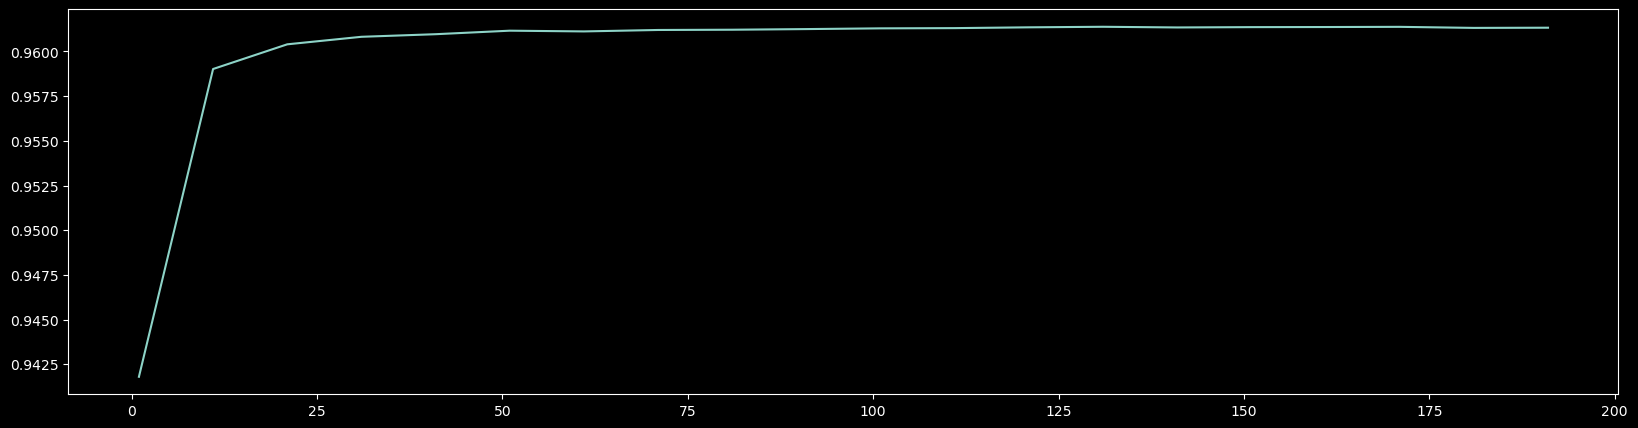

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
data = train_data.iloc[:,:-1]
lable = train_data.iloc[:,-1]
start=time.time()
scorel = []
for i in range(0,200,10): # 迭代建立包含0-200棵决策树的RF模型进行对比
  rfc = RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=90)
  score = cross_val_score(rfc,data,lable,cv=10).mean()
  scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
end=time.time()
print('Running time: %s Seconds'%(end-start))
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

data = train_data.iloc[:,:-1]
lable = train_data.iloc[:,-1]

start=time.time()
param_grid = {'max_depth':np.arange(19, 40, 2)} 
alg = RandomForestClassifier(n_estimators=131,random_state=1,n_jobs = -1) 
GS = GridSearchCV(alg,param_grid,cv=10) 
GS.fit(data,lable)
print(GS.best_params_)
print(GS.best_score_)
end=time.time()
print('Running time: %s Seconds'%(end-start))

{'max_depth': 33}
0.9614808711849836
Running time: 4008.5140051841736 Seconds


In [ ]:
numbers = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
for number in numbers:
    clf = RandomForestClassifier(n_jobs=-1,
                                 n_estimators=131,
                                 max_depth=33,
                                 max_features=number)
    clf.fit(
        train_data.drop(['target'], axis=1),
        train_data['target']
    )
    y_pred = clf.predict(X_val)

    # 计算准确率
    accuracy = accuracy_score(y_val, y_pred)
    print("Accuracy:", accuracy,number)
    
    # 计算F1分数
    f1 = f1_score(y_val, y_pred)
    print("F1 score:", f1,number) 